# LDA TOPIC MODELING 

This notebook applies LDA modeling to a dataset from a Kaggle dataset of news headlines:

https://www.kaggle.com/therohk/million-headlines

using GENSIM toolkit:

https://radimrehurek.com/gensim/

and following a really useful tutorial from machinelearningplus website:

https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/



__Steps__

- Text porcessing
- Bulding the model

__Other interesting links:__

- https://en.wikipedia.org/wiki/Latent_Dirichlet_allocation

- https://www.analyticsvidhya.com/blog/2016/08/beginners-guide-to-topic-modeling-in-python/

- https://medium.com/@lettier/how-does-lda-work-ill-explain-using-emoji-108abf40fa7d

- https://stackoverflow.com/questions/20984841/topic-distribution-how-do-we-see-which-document-belong-to-which-topic-after-doi

- https://datascienceplus.com/evaluation-of-topic-modeling-topic-coherence/

__Required Libraries__

In [1]:
import pandas as pd
import numpy as np


import string
import re
from pprint import pprint

# NLTK 
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import stopwords
stop_words = stopwords.words('english') #this depends on each language

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  
import matplotlib.pyplot as plt
%matplotlib inline

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

__Loading data__

In [8]:
df = pd.read_csv("./listing_207900withimages_927.csv", index_col = 0) 

C:\Users\yulier\Anaconda3\envs\insight\lib\site-packages\IPython\core\interactiveshell.py:3058: DtypeWarning: Columns (29,37,41,42,43,45,47,50,53) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [9]:
df.shape[0]

207900

In [10]:
df.head(1)

,listing_id,state,user_id,category_id,title,description,creation_tsz,ending_tsz,original_creation_tsz,last_modified_tsz,...,file_data,should_auto_renew,language,has_variations,taxonomy_id,taxonomy_path,used_manufacturer,Images,suggested_taxonomy_id,error_messages
0,663885606,active,10324319.0,69150393.0,St. Martin de Porres Dominican saint crochet a...,Handmade crochet doll of saint Martin de Porre...,1.569560e+09,1.580104e+09,1.548395e+09,1.569560e+09,...,NaN,True,en-US,False,1607.0,"['Toys & Games', 'Toys', 'Dolls & Action Figur...",False,"[{'listing_image_id': 1804970019, 'hex_code': ...",NaN,NaN


In [12]:
data=df['title'].values.tolist()

In [13]:
pprint(data[:1])

['St. Martin de Porres Dominican saint crochet amigurumi kokeshi doll, '
 'catholic, kids gift, Easter basket stuffer, baby toy, nursery decor']


__Tokenize words and Clean-up text__

In [14]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(data))

print(data_words[:1])

[['st', 'martin', 'de', 'porres', 'dominican', 'saint', 'crochet', 'amigurumi', 'kokeshi', 'doll', 'catholic', 'kids', 'gift', 'easter', 'basket', 'stuffer', 'baby', 'toy', 'nursery', 'decor']]


__Bigrams & Trigrams__

Bigrams are two words frequently occurring together in the document. Trigrams are 3 words frequently occurring.

In [15]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
print(trigram_mod[bigram_mod[data_words[0]]])

['st', 'martin_de_porres', 'dominican', 'saint', 'crochet', 'amigurumi', 'kokeshi', 'doll', 'catholic', 'kids', 'gift', 'easter', 'basket_stuffer', 'baby', 'toy', 'nursery', 'decor']


__Remove Stopwords, Make Bigrams and Lemmatize__

In [16]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

__Let’s call the functions in order__

In [17]:
#To run this code it is necessary to get the spacy moidel: "!python - m spacy download en", last depends on the used language 

# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'es' model, keeping only tagger component (for efficiency)
# python3 -m spacy download es
nlp = spacy.load('en', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[:1])

[['martin', 'dominican', 'saint', 'crochet', 'amigurumi', 'kokeshi', 'doll', 'catholic', 'kid', 'gift', 'easter', 'basket', 'stuffer', 'baby', 'toy', 'nursery', 'decor']]


__Create the Dictionary and Corpus needed for Topic Modeling__

In [18]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])

[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1), (15, 1), (16, 1)]]


If you want to see what word a given id corresponds to, pass the id as a key to the dictionary

In [19]:
id2word[0]

'amigurumi'

Or, you can see a human-readable form of the corpus itself.

In [20]:
# Human readable format of corpus (term-frequency)
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:2]]

[[('amigurumi', 1),
  ('baby', 1),
  ('basket', 1),
  ('catholic', 1),
  ('crochet', 1),
  ('decor', 1),
  ('doll', 1),
  ('dominican', 1),
  ('easter', 1),
  ('gift', 1),
  ('kid', 1),
  ('kokeshi', 1),
  ('martin', 1),
  ('nursery', 1),
  ('saint', 1),
  ('stuffer', 1),
  ('toy', 1)],
 [('baby', 1),
  ('kid', 1),
  ('toy', 2),
  ('accessory', 1),
  ('animal', 1),
  ('cute', 1),
  ('deer', 1),
  ('knit', 2),
  ('new', 1),
  ('newborn', 1),
  ('photo', 1),
  ('photography', 1),
  ('prop', 1),
  ('ready', 1),
  ('ship', 1),
  ('shoot', 1),
  ('umigurumi', 1),
  ('year', 1)]]

__Building the Topic Model__

In [21]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=20, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=4,
                                           alpha='auto',
                                           per_word_topics=True)

__View the topics in LDA model__

In [22]:
# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.421*"mask" + 0.204*"box" + 0.171*"card" + 0.105*"inspire" + 0.042*"face" '
  '+ 0.020*"fall" + 0.007*"yoga" + 0.000*"cpsc_compliant" + 0.000*"machine" + '
  '0.000*"stitch"'),
 (1,
  '0.633*"kid" + 0.170*"make" + 0.157*"pink" + 0.008*"apple" + 0.007*"cherry" '
  '+ 0.003*"etsy" + 0.002*"science" + 0.002*"pie" + 0.000*"teepee" + '
  '0.000*"tent"'),
 (2,
  '0.224*"knit" + 0.212*"board" + 0.107*"accessory" + 0.073*"new" + '
  '0.064*"ship" + 0.062*"mini" + 0.061*"ready" + 0.048*"photo" + 0.033*"deer" '
  '+ 0.033*"gray"'),
 (3,
  '0.297*"play" + 0.212*"feel" + 0.088*"pretend" + 0.087*"children" + '
  '0.078*"food" + 0.055*"kitchen" + 0.040*"halloween" + 0.033*"tea" + '
  '0.026*"costume" + 0.017*"fruit"'),
 (4,
  '0.232*"soft" + 0.156*"hand" + 0.103*"cat" + 0.094*"piece" + 0.092*"unicorn" '
  '+ 0.054*"jigsaw" + 0.036*"big" + 0.035*"table" + 0.034*"crayon" + '
  '0.033*"bird"'),
 (5,
  '0.651*"set" + 0.238*"puppet" + 0.080*"finger" + 0.000*"teepee" + '
  '0.000*"chess" + 0.000*

__Compute Model Perplexity and Coherence Score__

In [23]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -16.151604619544063

Coherence Score:  0.36055390408561866


__Visualize the topics-keywords__

In [24]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

C:\Users\yulier\Anaconda3\envs\insight\lib\site-packages\pyLDAvis\_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
12     0.205686  0.147335       1        1  15.676909
10     0.150340  0.080738       2        1  10.107899
9      0.191159 -0.275466       3        1  10.034828
13     0.128314  0.061836       4        1   7.693328
14     0.101526 -0.231759       5        1   5.875176
19     0.036938  0.010769       6        1   5.374604
3      0.071131  0.026173       7        1   5.068755
17     0.015214  0.003142       8        1   4.757308
18     0.024631  0.215312       9        1   4.653656
4     -0.018156 -0.008086      10        1   4.330417
1     -0.012781 -0.005971      11        1   4.235459
6      0.004246 -0.001168      12        1   4.211390
15    -0.030206 -0.011104      13        1   3.411277
2     -0.041214  0.163557      14        1   3.135759
16    -0.097393 -0.026049      15        1   2.843783
5     -0.123407 -0.029682      16        1   2.350371
11    -0.108022 -0.027547      17        1   2.329100
7     -0.157180 -0.034526      18        1   2.116344
0     -0.117247 -0.028890      19        1   1.670179
8     -0.223577 -0.028612      20        1   0.123457, topic_info=    Category           Freq      Term          Total  loglift  logprob
16   Default  187784.000000       toy  187784.000000  30.0000  30.0000
6    Default   98961.000000      doll   98961.000000  29.0000  29.0000
9    Default   85864.000000      gift   85864.000000  28.0000  28.0000
59   Default  109874.000000     child  109874.000000  27.0000  27.0000
10   Default   58518.000000       kid   58518.000000  26.0000  26.0000
..       ...            ...       ...            ...      ...      ...
706  Topic20       0.063485  silicone       1.634052   3.4490 -10.6561
630  Topic20       0.063481      long       1.633863   3.4491 -10.6561
767  Topic20       0.063483    flower       1.634065   3.4490 -10.6561
475  Topic20       0.063482      grey       1.634083   3.4490 -10.6561
569  Topic20       0.063480    softie       1.634031   3.4490 -10.6561

[762 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
17       14  0.999791  accessory
347       5  0.999886   activity
37        9  0.999286      adult
154       1  0.998590   airplane
319       3  0.999551   alphabet
...     ...       ...        ...
57        3  0.999969     wooden
69        9  0.999292       work
31        3  0.999584       year
124       5  0.999549     yellow
280      19  0.995101       yoga

[280 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[13, 11, 10, 14, 15, 20, 4, 18, 19, 5, 2, 7, 16, 3, 17, 6, 12, 8, 1, 9])

__Building LDA Mallet Model__

The MALLET topic model package includes an extremely fast and highly scalable implementation of Gibbs sampling, efficient methods for document-topic hyperparameter optimization, and tools for inferring topics for new documents given trained models. 

In [29]:
import os
os.environ.update({'MALLET_HOME':r'C:/Work/Projects/Insight/data/LDA-Topic-Modeling-master/Python/mallet-2.0.8/'})
# Download File: http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
mallet_path = 'C:\\Work\\Projects\\Insight\\data\\LDA-Topic-Modeling-master\\Python\\mallet-2.0.8\\bin\mallet'#./mallet-2.0.8/bin/mallet' # update this path
ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=20, id2word=id2word)

In [30]:
# Show Topics
pprint(ldamallet.show_topics(formatted=False))

# Compute Coherence Score
coherence_model_ldamallet = CoherenceModel(model=ldamallet, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()
print('\nCoherence Score: ', coherence_ldamallet)

[(8,
  [('baby', 0.28289381694118965),
   ('decor', 0.09486656039971289),
   ('nursery', 0.06138314829833049),
   ('pillow', 0.05414953811161759),
   ('shower', 0.046431201469094026),
   ('room', 0.04138818199614083),
   ('gift', 0.0346206549400151),
   ('owl', 0.028580217567605357),
   ('decoration', 0.02545746059267131),
   ('mobile', 0.02402192455046282)]),
 (16,
  [('girl', 0.09251670242731774),
   ('bag', 0.07020612371490456),
   ('fairy', 0.050356420138500495),
   ('waldorf', 0.04144845890236834),
   ('boy', 0.040268865861967276),
   ('angel', 0.028330570780666878),
   ('school', 0.02744587600036608),
   ('tooth', 0.025249392407895137),
   ('child', 0.024578244643529017),
   ('flower', 0.024263008572387355)]),
 (18,
  [('crochet', 0.19981054081984154),
   ('handmade', 0.11420082673096796),
   ('toy', 0.11307268343093352),
   ('amigurumi', 0.10584739924216328),
   ('knit', 0.08574750258353428),
   ('bunny', 0.07952979676197038),
   ('rabbit', 0.04605580434033758),
   ('soft', 0.03

__How to find the optimal number of topics for LDA?__

My approach to finding the optimal number of topics is to build many LDA models with different values of number of topics (k) and pick the one that gives the highest coherence value.

Choosing a ‘k’ that marks the end of a rapid growth of topic coherence usually offers meaningful and interpretable topics. Picking an even higher value can sometimes provide more granular sub-topics.

If you see the same keywords being repeated in multiple topics, it’s probably a sign that the ‘k’ is too large.

The compute_coherence_values() (see below) trains multiple LDA models and provides the models and their corresponding coherence scores.

In [31]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [32]:
# Can take a long time to run.
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=2, limit=40, step=6)

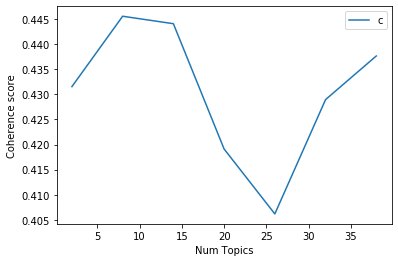

In [33]:
# Show graph
limit=40; start=2; step=6;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [34]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of 0.4315
Num Topics = 8  has Coherence Value of 0.4456
Num Topics = 14  has Coherence Value of 0.4441
Num Topics = 20  has Coherence Value of 0.4191
Num Topics = 26  has Coherence Value of 0.4062
Num Topics = 32  has Coherence Value of 0.429
Num Topics = 38  has Coherence Value of 0.4376


In [35]:
# Select the model and print the topics
optimal_model = model_list[1]
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=10))

[(0,
  '0.188*"gift" + 0.124*"baby" + 0.042*"birthday" + 0.038*"decor" + '
  '0.035*"child" + 0.030*"christmas" + 0.030*"boy" + 0.024*"nursery" + '
  '0.021*"custom" + 0.018*"shower"'),
 (1,
  '0.227*"doll" + 0.063*"quot" + 0.043*"handmade" + 0.040*"girl" + '
  '0.021*"dress" + 0.018*"inch" + 0.018*"fabric" + 0.017*"clothe" + '
  '0.016*"pink" + 0.016*"chart"'),
 (2,
  '0.236*"toy" + 0.128*"vintage" + 0.085*"wooden" + 0.036*"wood" + '
  '0.022*"block" + 0.017*"car" + 0.016*"collectible" + 0.012*"barbie" + '
  '0.012*"natural" + 0.012*"plastic"'),
 (3,
  '0.072*"set" + 0.070*"child" + 0.064*"play" + 0.055*"feel" + 0.023*"mask" + '
  '0.022*"pillow" + 0.022*"pretend" + 0.021*"food" + 0.019*"party" + '
  '0.019*"fairy"'),
 (4,
  '0.152*"toy" + 0.078*"crochet" + 0.074*"animal" + 0.064*"stuff" + '
  '0.061*"bear" + 0.060*"plush" + 0.041*"amigurumi" + 0.040*"soft" + '
  '0.035*"handmade" + 0.033*"knit"'),
 (5,
  '0.111*"kid" + 0.099*"child" + 0.095*"puzzle" + 0.033*"teepee" + '
  '0.024*"ten

__Finding the dominant topic in each sentence__

In [ ]:
def format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=data)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
df_dominant_topic.head(10)

In [26]:
df_dominant_topic.shape

(1103665, 5)

__Find the most representative document for each topic__

In [28]:
# Group top 5 sentences under each topic
sent_topics_sorteddf_mallet = pd.DataFrame()

sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=[0]).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]

# Show
sent_topics_sorteddf_mallet.head()

,Topic_Num,Topic_Perc_Contrib,Keywords,Text
0,0.0,0.1791,"farmer, price, china, deal, industry, company,...",glyphosate herbicide crops grain weeds livesto...
1,1.0,0.1518,"hospital, boost, health, service, fund, govt, ...",hospitals to receive extra emergency ward funding
2,2.0,0.1647,"plan, govt, power, nt, mine, vic, tas, decisio...",springsure creek coal mine plan gets environme...
3,3.0,0.1667,"man, charge, court, face, murder, jail, accuse...",jury acquits man accused of ivy nightclub rape
4,4.0,0.1647,"fire, warn, home, fear, house, spark, bushfire...",fire retardant foam engulfs californian airpor...


__Topic distribution across documents__

In [29]:
# Number of Documents for Each Topic
topic_counts = df_topic_sents_keywords['Dominant_Topic'].value_counts()

# Percentage of Documents for Each Topic
topic_contribution = round(topic_counts/topic_counts.sum(), 4)

# Topic Number and Keywords
topic_num_keywords = df_topic_sents_keywords[['Dominant_Topic', 'Topic_Keywords']]

# Concatenate Column wise
df_dominant_topics = pd.concat([topic_num_keywords, topic_counts, topic_contribution], axis=1)

# Change Column names
df_dominant_topics.columns = ['Dominant_Topic', 'Topic_Keywords', 'Num_Documents', 'Perc_Documents']

# Show
df_dominant_topics.head()

,Dominant_Topic,Topic_Keywords,Num_Documents,Perc_Documents
0,2.0,"plan, govt, power, nt, mine, vic, tas, decisio...",80643.0,0.0731
1,4.0,"fire, warn, home, fear, house, spark, bushfire...",71120.0,0.0644
2,1.0,"hospital, boost, health, service, fund, govt, ...",62728.0,0.0568
3,11.0,"rise, worker, job, union, pay, cut, rate, offe...",78086.0,0.0708
4,4.0,"fire, warn, home, fear, house, spark, bushfire...",55763.0,0.0505
